# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

Build nodel architecture

In [81]:
import keras
import keras.layers as layers
from keras.layers import InputLayer, Input, Dense, MultiHeadAttention, LayerNormalization, Conv1D, Dropout

def transformer_encoder(inputs, head_size, num_heads, ff_dim, bias, mh_drop = 0, ff_drop = 0, useMHA = True):
    # Attention and Normalization
    if useMHA:
        if bias is None:
            bias = True
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=mh_drop, use_bias = bias
        )(query = inputs, value = inputs) #key is optional
        x = layers.Dropout(mh_drop)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        #residual bypass connection
        res = x + inputs
    else: #skip MHA
        res = inputs
    # Feed Forward Block and Normalization
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
    x = layers.Dropout(ff_drop)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    # residual bypass connection
    x = x + res
    return x
def build_transformer_encoder_model(
    input_shape,
    head_size,
    num_heads,
    ff_dim,
    bias,
    num_transformer_blocks,
    mh_drop,
    ff_drop,
    out_pooling,
    mlp_units,
    mlp_activation,
    n_classes,
    mlp_dropout,
    out_type,
    out_shape,
    out_act
    ):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    #transformer block stack
    useMHA = True
    if input_shape[-2] == 1:
        useMHA = False
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, bias, mh_drop, ff_drop, useMHA)
    #reshape sequence to a single vector
    match out_pooling:
        case 'AVG':
            x = layers.GlobalAveragePooling1D(data_format="channels_last")(x)
        case 'MAX':
            x = layers.GlobalMaxPooling1D(data_format="channels_last")(x)
        case 'LAST':
            if input_shape[-2] > 1:
                x = layers.Cropping1D(cropping=(input_shape[-2]-1, 0))(x)
            x = layers.Flatten()(x)
        case 'LSTM':
            x = layers.LSTM(input_shape[-2])(x)
        case _:
            raise NotImplementedError(f'{out_pooling} is not implemented.')
    #output pre-processing block
    for i, dim in enumerate(mlp_units):
        x = layers.Dense(dim, activation=mlp_activation)(x)
        x = layers.Dropout(mlp_dropout)(x)
    if out_type == 'vect':
        outputs = layers.Dense(n_classes, activation=out_act)(x)
    else: #categories
        outputs = layers.Dense(out_shape, activation=out_act)(x)

    return keras.Model(inputs, outputs)

In [72]:
import numpy as np
def pos_encoder_sinecosine(seq_len:int, d:int, n:int=10000):
    r = np.zeros((seq_len, d))
    for k in range(seq_len):
        for i in np.arange(int(d/2)):
            denominator = np.power(n, 2*i/d)
            r[k, 2*i] = np.sin(k/denominator)
            r[k, 2*i+1] = np.cos(k/denominator)
    return r

def apply_pos_encoder(t:np.ndarray, pe:np.ndarray):
    for i in range(t.shape[0]):
        t[i] = t[i] + pe
    return t

In [68]:
import pandas as pd
from IPython.display import display
pd.set_option('display.max_columns', 20)

seq_len = 30
xcols = ['MOY', 'new_hat', 'HolidayTomorrow', 'WeekendTomorrow', 'picnic', 'is_sick', 'Temp', 'Temp_NextForecast', 'Prec_NextForecast', 'Precipitation', ]
ycols = ['hat']
naive_pred_cols = ['naive_prediction']
train_rows, test_rows  = 15500, 1200

data_file = 'weather_data_with_forecasts_and_hat_state.csv'
data = pd.read_csv(data_file)
data = data[xcols + ycols + naive_pred_cols]
df = data.iloc[:train_rows + test_rows, :].copy()
display(df.head())

,MOY,new_hat,HolidayTomorrow,WeekendTomorrow,picnic,is_sick,Temp,Temp_NextForecast,Prec_NextForecast,Precipitation,hat,naive_prediction
0,1,0,0,0,0,1,39,39.0,0.0,0.0,0,1
1,1,0,0,1,0,1,39,49.0,0.2,0.0,0,0
2,1,0,0,1,0,1,46,48.0,0.0,0.16,0,0
3,1,0,0,0,0,1,45,36.0,0.0,0.0,0,0
4,1,0,0,0,0,1,34,38.0,0.1,0.01,0,0


In [69]:
pd.set_option('display.max_columns', 20)
df.loc[:,'hat_next'] = df['hat'].shift(-1)
df = df.dropna()
df.reset_index(drop=True)
rp_indexer = df[['hat_next']].copy()
rp_indexer['seq_elems'] = [[] for x in range(len(rp_indexer))]
rp_indexer['sequence_len'] = 0
for i in range(seq_len-1, len(rp_indexer)):
    list_start = max(0, i - seq_len + 1)
    elements = list(range(list_start, i + 1))
    rp_indexer.at[i, 'seq_elems'].extend(elements)
    rp_indexer.at[i, 'sequence_len'] = len(elements)
rp_indexer = rp_indexer.loc[rp_indexer['sequence_len'] == seq_len]
df = df.iloc[rp_indexer.at[rp_indexer.first_valid_index(), 'seq_elems'][0]:,]
display(rp_indexer.iloc[rp_indexer.first_valid_index():rp_indexer.first_valid_index()+5])

,hat_next,seq_elems,sequence_len
58,0.0,"[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]",30
59,1.0,"[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]",30
60,1.0,"[31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60]",30
61,1.0,"[32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]",30
62,1.0,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]",30


In [70]:
pd.set_option('display.max_columns', 20)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(df.loc[df.index[0]:df.index[train_rows-1], xcols + ycols].to_numpy())
df[xcols + ycols] = scaler.transform(df[xcols + ycols].to_numpy())
display(df.iloc[df.index.min():df.index.min() + 4])

,MOY,new_hat,HolidayTomorrow,WeekendTomorrow,picnic,is_sick,Temp,Temp_NextForecast,Prec_NextForecast,Precipitation,hat,naive_prediction,hat_next
0,0.0,0.0,0.0,0.0,0.0,1.0,0.5196850393700787,0.4814814814814815,0.0,0.0,0.0,1,0.0
1,0.0,0.0,0.0,1.0,0.0,1.0,0.5196850393700787,0.5555555555555556,0.006779661016949153,0.0,0.0,0,0.0
2,0.0,0.0,0.0,1.0,0.0,1.0,0.5748031496062993,0.5481481481481482,0.0,0.007659167065581618,0.0,0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.5669291338582677,0.45925925925925926,0.0,0.0,0.0,0,0.0


In [71]:
import numpy as np
stacked_x, stacked_y = None, None
for i in rp_indexer.index:
    curr_seq = df.loc[df.index.isin(rp_indexer['seq_elems'].at[i]), xcols + ycols].to_numpy()
    curr_r = df.loc[i:i, 'hat_next'].to_numpy()
    if stacked_x is None:
        stacked_x = curr_seq[None]
        stacked_y = curr_r[None]
    else:
        stacked_x = np.vstack((stacked_x, curr_seq[None]))
        stacked_y = np.vstack((stacked_y, curr_r[None]))

In [50]:
np.set_printoptions(suppress=True)
print(stacked_x[0])

[[ 1.    0.    0.    0.    0.    1.   39.   39.    0.    0.    0.  ]
 [ 1.    0.    0.    1.    0.    1.   39.   49.    0.2   0.    0.  ]
 [ 1.    0.    0.    1.    0.    1.   46.   48.    0.    0.16  0.  ]
 [ 1.    0.    0.    0.    0.    1.   45.   36.    0.    0.    0.  ]
 [ 1.    0.    0.    0.    0.    1.   34.   38.    0.1   0.01  0.  ]
 [ 1.    0.    0.    0.    0.    1.   38.   29.    0.1   0.09  0.  ]
 [ 1.    0.    0.    0.    0.    1.   30.   21.    0.1   0.05  0.  ]
 [ 1.    0.    0.    0.    0.    0.   22.   31.    0.5   0.15  1.  ]
 [ 1.    0.    0.    1.    0.    0.   34.   40.    3.1   0.6   1.  ]
 [ 1.    0.    0.    1.    0.    0.   38.   28.    0.    2.15  0.  ]
 [ 1.    0.    0.    0.    0.    0.   31.   14.    0.    0.    0.  ]
 [ 1.    0.    0.    0.    0.    0.   14.   28.    0.    0.    1.  ]
 [ 1.    0.    0.    0.    0.    0.   27.   41.    0.    0.02  1.  ]
 [ 1.    0.    0.    0.    0.    0.   39.   39.    0.2   1.22  1.  ]
 [ 1.    0.    0.    0.    0.    0

In [73]:
train_data, test_data = {}, {}
train_data['X'] = stacked_x[:train_rows]
train_data['y'] = stacked_y[:train_rows]
test_data['X'] = stacked_x[train_rows:]
test_data['y'] = stacked_y[train_rows:]
x_shape, ts_x_shape = train_data['X'].shape, test_data['X'].shape

pe = pos_encoder_sinecosine(seq_len = seq_len, d = x_shape[2])
train_data['X'] = apply_pos_encoder(train_data['X'], pe)
test_data['X'] = apply_pos_encoder(test_data['X'], pe)
print(pe)

[[ 0.          1.          0.          1.          0.          1.
   0.          1.          0.          1.          0.        ]
 [ 0.84147098  0.54030231  0.18628711  0.98249535  0.0351047   0.99938364
   0.00657928  0.99997836  0.00123285  0.99999924  0.        ]
 [ 0.90929743 -0.41614684  0.36605244  0.93059422  0.07016613  0.99753532
   0.01315828  0.99991343  0.00246569  0.99999696  0.        ]
 [ 0.14112001 -0.9899925   0.53300253  0.84611365  0.10514107  0.99445732
   0.01973672  0.99980521  0.00369853  0.99999316  0.        ]
 [-0.7568025  -0.65364362  0.68129257  0.73201122  0.13998639  0.99015343
   0.02631429  0.99965372  0.00493137  0.99998784  0.        ]
 [-0.95892427  0.28366219  0.80573104  0.5922816   0.17465915  0.98462896
   0.03289073  0.99945895  0.00616419  0.999981    0.        ]
 [-0.2794155   0.96017029  0.90196143  0.43181661  0.2091166   0.97789071
   0.03946574  0.99922092  0.00739701  0.99997264  0.        ]
 [ 0.6569866   0.75390225  0.96661478  0.25623402

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11      │ (None, 30, 11)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 11)    │     72,203 │ input_layer_11[0… │
│ (MultiHeadAttentio… │                   │            │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_75          │ (None, 30, 11)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 11)    │         22 │ dropout_75[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_44 (Add)        │ (None, 30, 11)    │          0 │ layer_normalizat… │
│                     │                   │            │ input_layer_11[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 30, 12)    │        144 │ add_44[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_76          │ (None, 30, 12)    │          0 │ conv1d_44[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 30, 11)    │        143 │ dropout_76[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 11)    │         22 │ conv1d_45[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_45 (Add)        │ (None, 30, 11)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_44[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 11)    │     72,203 │ add_45[0][0],     │
│ (MultiHeadAttentio… │                   │            │ add_45[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_78          │ (None, 30, 11)    │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 11)    │         22 │ dropout_78[0][0]  │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_46 (Add)        │ (None, 30, 11)    │          0 │ layer_normalizat… │
│                     │                   │            │ add_45[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 30, 12)    │        144 │ add_46[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_79          │ (None, 30, 12)    │          0 │ conv1d_46[0][0]   │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 30, 11)    │        143 │ dropout_79[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 11)    │         22 │ conv1d_47[0][0]   │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 145,485 (568.30 KB)

 Trainable params: 145,485 (568.30 KB)

 Non-trainable params: 0 (0.00 B)

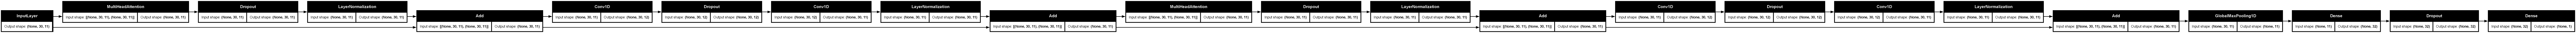

In [112]:
from keras.optimizers import Adam
from keras.utils import plot_model
m =build_transformer_encoder_model(
            x_shape[1:],
            head_size=256,
            num_heads=6,
            ff_dim=12,
            bias=True,
            mh_drop=0.15,
            ff_drop=0.25,
            out_pooling = 'MAX',
            num_transformer_blocks=2,
            mlp_units=[32],
            mlp_activation='linear',
            mlp_dropout=0.3,
            out_type='categories',
            n_classes= train_data['y'].shape[-1],
            out_shape= train_data['y'].shape[-1],
            out_act='sigmoid'
        )
m.compile(optimizer=Adam(amsgrad = True), loss='binary_crossentropy', metrics=['binary_crossentropy', 'accuracy'])
m.summary(expand_nested=True)
dot_img_file = 'model_plot.png'
keras.utils.plot_model(m, rankdir = 'LR', to_file=dot_img_file, show_shapes=True)

In [95]:
y_data = train_data['y'].reshape(train_data['y'].shape[0], 1)
fit_hist = m.fit(train_data['X'], y_data, shuffle=True, epochs=10,  batch_size=4, validation_split=0.2, verbose = 0)

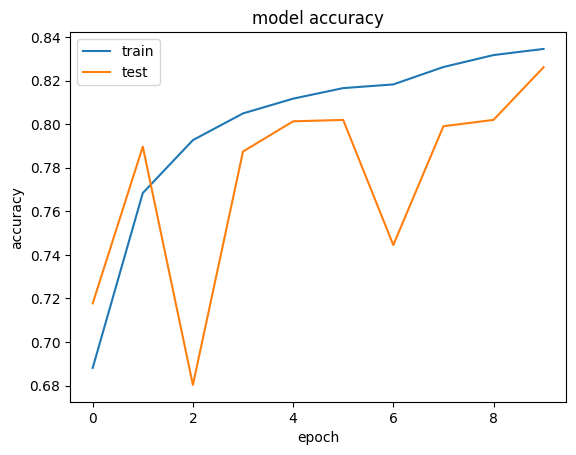

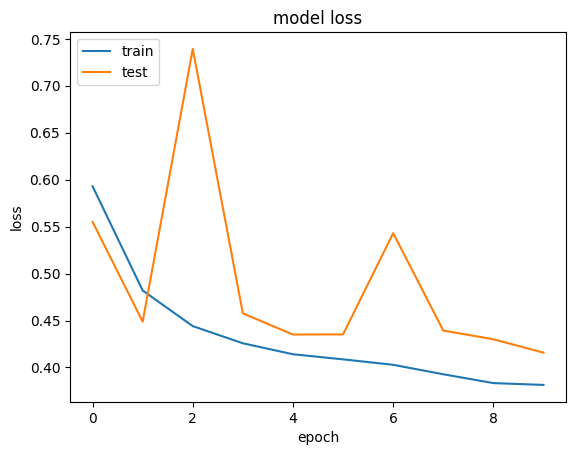

In [96]:
import matplotlib.pyplot as plt
#accuracy history
plt.plot(fit_hist.history['accuracy'])
plt.plot(fit_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
#loss history
plt.plot(fit_hist.history['loss'])
plt.plot(fit_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [102]:
predictions = m.predict(test_data['X'], batch_size=1, verbose=0)
actual = test_data['y'].reshape(test_data['y'].shape[0], )
predictions = predictions.reshape(predictions.shape[0]).tolist()
actual  = actual.reshape(actual.shape[0]).tolist()
print(predictions[:10])
print(actual[:10])

[0.006884158123284578, 0.403127521276474, 0.023512348532676697, 0.13634991645812988, 0.15711437165737152, 0.04560905322432518, 0.07966544479131699, 0.30704641342163086, 0.98256915807724, 0.9901009798049927]
[0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0]


In [104]:
predictions = [1 if p >= 0.5 else 0 for p in predictions]
actual = [int(a) for a in actual]
print(predictions[:10])
print(actual[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 1, 1]
[0, 0, 0, 0, 1, 1, 0, 1, 1, 1]


In [108]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(actual, predictions, normalize = 'all').ravel().tolist()
cm_model = f'\tTN: {round(tn,3):.3f}\t FP: {round(fp,3):.3f}\n\tFN: {round(fn,3):.3f}\t TP: {round(tp,3):.3f}'
acc_naive = round(100 * (tn + tp), 2)
prec_naive, rec_naive = round(100 * (tp / (tp + fp + 0.0000001)), 2), round(100 * (tp / (tp + fn + 0.0000001)), 2)
print('confusion matrix:')
print(cm_model)
print(f'accuracy: {acc_naive}, precision: {prec_naive}, recall: {rec_naive}\n')

confusion matrix:
	TN: 0.323	 FP: 0.046
	FN: 0.080	 TP: 0.550
accuracy: 87.35, precision: 92.26, recall: 87.26

